# Preprocessing

This notebook covers the preprocessing for the cleaned data. The preprocessing will include PCA, and feature selection. It will have various pipelines that can be used to train different sets of processed data to compare the results of a machine learning model. 

Import Libraries

In [1]:
#basic libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing and modelling libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')

Before we begin preprocessing, we will run some simple models to determine a baseline. This baseline can then be used as a benchmark after completing other preprocessing steps.

### Importing Cleaned Data

In [2]:
data = pd.read_csv('..\data\kois_cleaned.csv', index_col=0)
kois = data.copy()
kois.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_disposition_encoded
rowid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
2,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
3,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,...,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,2
4,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,...,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,2
5,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,...,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1


In [3]:
#exclude error columns with .describe()
kois.loc[:, ~kois.columns.str.contains('_err')].describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,koi_disposition_encoded
count,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000
mean,0.167203,0.235039,0.197402,0.122238,75.093189,165.792699,0.722475,5.636540,2.293444e+04,102.880978,1077.611302,7.325554e+03,262.226624,5704.450094,4.310499,1.699245,292.047428,43.828852,14.268715,1.265238
std,0.373178,0.424047,0.398060,0.327579,1375.035264,67.589891,3.296483,6.409275,8.078573e+04,3109.455176,843.714627,1.584377e+05,803.003738,797.670670,0.430133,5.622511,4.760429,3.598752,1.348588,0.821739
min,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,0.000000,0.167000,4.500000e+00,0.140000,25.000000,0.000000e+00,1.600000,2661.000000,0.047000,0.109000,279.852720,36.577381,6.966000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.741232,132.773544,0.196000,2.454245,1.603000e+02,1.400000,537.000000,1.960500e+01,12.100000,5301.000000,4.215000,0.827000,288.660770,40.810164,13.469000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,9.449426,137.157520,0.534000,3.823530,4.183000e+02,2.380000,875.000000,1.383400e+02,23.000000,5761.000000,4.440000,0.997000,292.249020,43.720329,14.534000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,37.597864,170.545120,0.886000,6.308000,1.413550e+03,14.375000,1372.000000,8.359150e+02,76.650000,6116.000000,4.544000,1.347000,295.856400,46.722311,15.319000,2.000000
max,1.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07,9054.700000,15896.000000,5.364000,180.013000,301.720760,52.336010,19.065000,2.000000


In [4]:
print(kois.shape)

(9007, 40)


### Splitting Data

In [5]:
#separate our target variable from the rest of the data
y = kois['koi_disposition_encoded']
X = kois.drop(['koi_disposition_encoded'], axis=1)

In [6]:
#print the percentage of values in each class
print(f"Percent of Total Dispositions for Each Target Variable: \n{y.value_counts(normalize=True)}")
print(f"\nTarget Variable Descriptive Statistics:\n{y.describe()}")


Percent of Total Dispositions for Each Target Variable: 
koi_disposition_encoded
2    0.505385
1    0.254469
0    0.240147
Name: proportion, dtype: float64

Target Variable Descriptive Statistics:
count    9007.000000
mean        1.265238
std         0.821739
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: koi_disposition_encoded, dtype: float64


In [7]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #use a test size of 20%

### Instantiating Models

In [8]:
#Decision tree classifier
dtc = DecisionTreeClassifier(random_state=23)

#Random forest classifier
rfc = RandomForestClassifier(random_state=23, n_jobs=-1)

#Logistic regression classifier
logreg = LogisticRegression(random_state=23, n_jobs=-1)

#Support vector machine classifier
svc = SVC(random_state=23)

#K-nearest neighbors classifier
knn = KNeighborsClassifier(n_jobs=-1)

#XGBoost classifier
xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=23, n_jobs=-1)

### Train the Models

In [9]:
#train Decision tree classifier
dtc.fit(X_train, y_train)

#train Random forest classifier
rfc.fit(X_train, y_train)

#train Logistic regression classifier
logreg.fit(X_train, y_train)

#train Support vector machine classifier
svc.fit(X_train, y_train)

#train K-nearest neighbors classifier
knn.fit(X_train, y_train)

#train XGBoost classifier
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

### Check Model Performance

In [10]:
# Decision tree classifier F1-score
dtc_f1_score = f1_score(y_test, dtc.predict(X_test), average='macro')

# Random forest classifier F1-score
rfc_f1_score = f1_score(y_test, rfc.predict(X_test), average='macro')

# Logistic regression classifier F1-score
logreg_f1_score = f1_score(y_test, logreg.predict(X_test), average='macro')

# Support vector machine classifier F1-score
svc_f1_score = f1_score(y_test, svc.predict(X_test), average='macro')

# K-nearest neighbors classifier F1-score
knn_f1_score = f1_score(y_test, knn.predict(X_test), average='macro')

# XGBoost classifier F1-score
xgbc_f1_score = f1_score(y_test, xgbc.predict(X_test), average='macro')

In [11]:
#Print the scores

# Create a dictionary with the model names and their scores
model_scores = {
    "Decision Tree": dtc_f1_score,
    "Random Forest": rfc_f1_score,
    "Logistic Regression": logreg_f1_score,
    "SVM": svc_f1_score,
    "KNN": knn_f1_score,
    "XGBoost": xgbc_f1_score
}

# Convert the dictionary to a DataFrame
scores_df = pd.DataFrame(list(model_scores.items()), columns=['Model-Base', 'F1-Score'])

# Sort the DataFrame by 'Accuracy Score' in descending order
scores_df = scores_df.sort_values(by='F1-Score', ascending=False)

# Display the DataFrame
print(scores_df)

base_report = classification_report(y_test, xgbc.predict(X_test))

print(f"\n{base_report}")


            Model-Base  F1-Score
1        Random Forest  0.864087
5              XGBoost  0.863201
0        Decision Tree  0.809189
4                  KNN  0.582187
2  Logistic Regression  0.469997
3                  SVM  0.219409

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       452
           1       0.80      0.82      0.81       466
           2       0.99      0.99      0.99       884

    accuracy                           0.89      1802
   macro avg       0.86      0.86      0.86      1802
weighted avg       0.89      0.89      0.89      1802



Now that we have the above accuracy scores, we have a benchmark to work with. We also know that the median is 2 for the target variable. And if you chose the median for every prediction you would be right approximately 50% of the time. Looking at the scores from our models, we can now see which models had the greatest gains over simply choosing the median every time. 

We can also see which models performed worse than our simplest guess. 

Before we cast judgment on the performance of these models, we have to remember that some are more sensitive to feature scaling than others. For example, Logistic Regression, SVM, and KNN all benefit greatly from feature scaling, while Decision Trees, Random Forest, and XGBoost all are typically invariant to feature scaling. 

What this tells us is that in order to utilize some of these models properly we should perform some sort of feature scaling on the data.

### Feature Scaling

For SVM and Logistic Regression, we will use the Z-score normalization or `StandardScaler()` from the Scikit Learn library. 

For KNN, we will use Min-Max scaling (normalization) or the `MinMaxScaler()` also from Scikit Learn. 

In [12]:
#fit the scalers to the train and test sets separately and transform both
scaler = StandardScaler()

X_train_stndrd = scaler.fit_transform(X_train)
X_test_stndrd = scaler.transform(X_test)

minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(X_train)
X_test_minmax = minmax.transform(X_test)

### Retrain Models

We can now use the scaled data to retrain our models. We can compare it with our tree models without scaled data, as well as pass the scaled data through the tree models to evaluate performance. These scores can act as our new benchmarks.

In [13]:
#training our tree and ensemble models on the scaled data
#train Decision tree classifier
dtc.fit(X_train_stndrd, y_train)

#train Random forest classifier
rfc.fit(X_train_stndrd, y_train)

#train XGBoost classifier
xgbc.fit(X_train_stndrd, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
#Training the remaining models on their preferred scaling method
#train Logistic regression classifier
logreg.fit(X_train_stndrd, y_train)

#train Support vector machine classifier
svc.fit(X_train_stndrd, y_train)

#train K-nearest neighbors classifier
knn.fit(X_train_minmax, y_train)

KNeighborsClassifier(n_jobs=-1)

In [15]:
# Decision tree classifier F1-score
dtc_f1_score = f1_score(y_test, dtc.predict(X_test_stndrd), average='macro')

# Random forest classifier F1-score
rfc_f1_score = f1_score(y_test, rfc.predict(X_test_stndrd), average='macro')

# Logistic regression classifier F1-score
logreg_f1_score = f1_score(y_test, logreg.predict(X_test_stndrd), average='macro')

# Support vector machine classifier F1-score
svc_f1_score = f1_score(y_test, svc.predict(X_test_stndrd), average='macro')

# K-nearest neighbors classifier F1-score
knn_f1_score = f1_score(y_test, knn.predict(X_test_minmax), average='macro')

# XGBoost classifier F1-score
xgbc_f1_score = f1_score(y_test, xgbc.predict(X_test_stndrd), average='macro')

In [16]:
#Print the scores

# Create a dictionary with the model names and their scores
model_scores_scaled = {
    "Decision Tree": dtc_f1_score,
    "Random Forest": rfc_f1_score,
    "Logistic Regression": logreg_f1_score,
    "SVM": svc_f1_score,
    "KNN": knn_f1_score,
    "XGBoost": xgbc_f1_score
}

# Convert the dictionary to a DataFrame
scores_scaled = pd.DataFrame(list(model_scores_scaled.items()), columns=['Model-Scaling', 'F1-Score'])

# Sort the DataFrame by 'Accuracy Score' in descending order
scores_scaled = scores_scaled.sort_values(by='F1-Score', ascending=False)

# Display the DataFrame for both sets of scores
print(scores_df)
print(scores_scaled)

print(f"\n Classification Report for Decision Tree using StandardScaler: \n{classification_report(y_test, dtc.predict(X_test_stndrd))}")
print(f"\n Classification Report for KNN using MinMaxScaler: \n{classification_report(y_test, knn.predict(X_test_minmax))}")
print(f"\n Classification Report for XGBoost using StandardScaler: \n{classification_report(y_test, xgbc.predict(X_test_stndrd))}")

            Model-Base  F1-Score
1        Random Forest  0.864087
5              XGBoost  0.863201
0        Decision Tree  0.809189
4                  KNN  0.582187
2  Logistic Regression  0.469997
3                  SVM  0.219409
         Model-Scaling  F1-Score
5              XGBoost  0.863201
1        Random Forest  0.859486
2  Logistic Regression  0.840385
3                  SVM  0.830852
0        Decision Tree  0.807556
4                  KNN  0.751324

 Classification Report for Decision Tree using StandardScaler: 
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       452
           1       0.71      0.76      0.73       466
           2       0.98      0.97      0.98       884

    accuracy                           0.85      1802
   macro avg       0.81      0.81      0.81      1802
weighted avg       0.85      0.85      0.85      1802


 Classification Report for KNN using MinMaxScaler: 
              precision    recall  f1-s

## EDIT THIS (BELOW) AS IT IS NOT CORRECT

We can see huge improvements in the accuracy just by applying scaling to our data for the the models that are typically sensitive to it. Our ensemble models maintained their performance rankings with only a minor change in the random forest performance and no change in the performance of XGBoost. 

Logistic Regression had the largest gain of 0.35. Every model is now performing in the 80% territory which is fairly strong when compared to our absolute base benchmark of always choosing the median. 

### Outliers

From the data cleaning and EDA notebook, we saw that there were potential outliers, not only in the data, but also in the error values. We opted to leave the outliers in due to a lack of domain knowledge. But as part of our preprocessing we can not remove some of those extreme values and compare performance.

We will start off with very conservative outlier removal, to see if this improves our performance. From what we saw in our data exploration notebook, most of the variables were left skewed, with their most extreme values existing in the positive direction. Eliminating outliers outside of IQR + 3 * $\sigma$ can help remove these extreme values. 

In [17]:
#Based on distributions we saw in our exploration notebook, let's take the log of the dataset, then remove outliers
kois_no_err = kois.loc[:, ~kois.columns.str.contains('_err')]
kois_log = kois_no_err.copy()
kois_log.iloc[:, 4:-1] = np.log1p(kois_no_err.iloc[:, 4:-1])
kois_log.shape

(9007, 20)

In [18]:
kois_log.columns[4:-1]

Index(['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

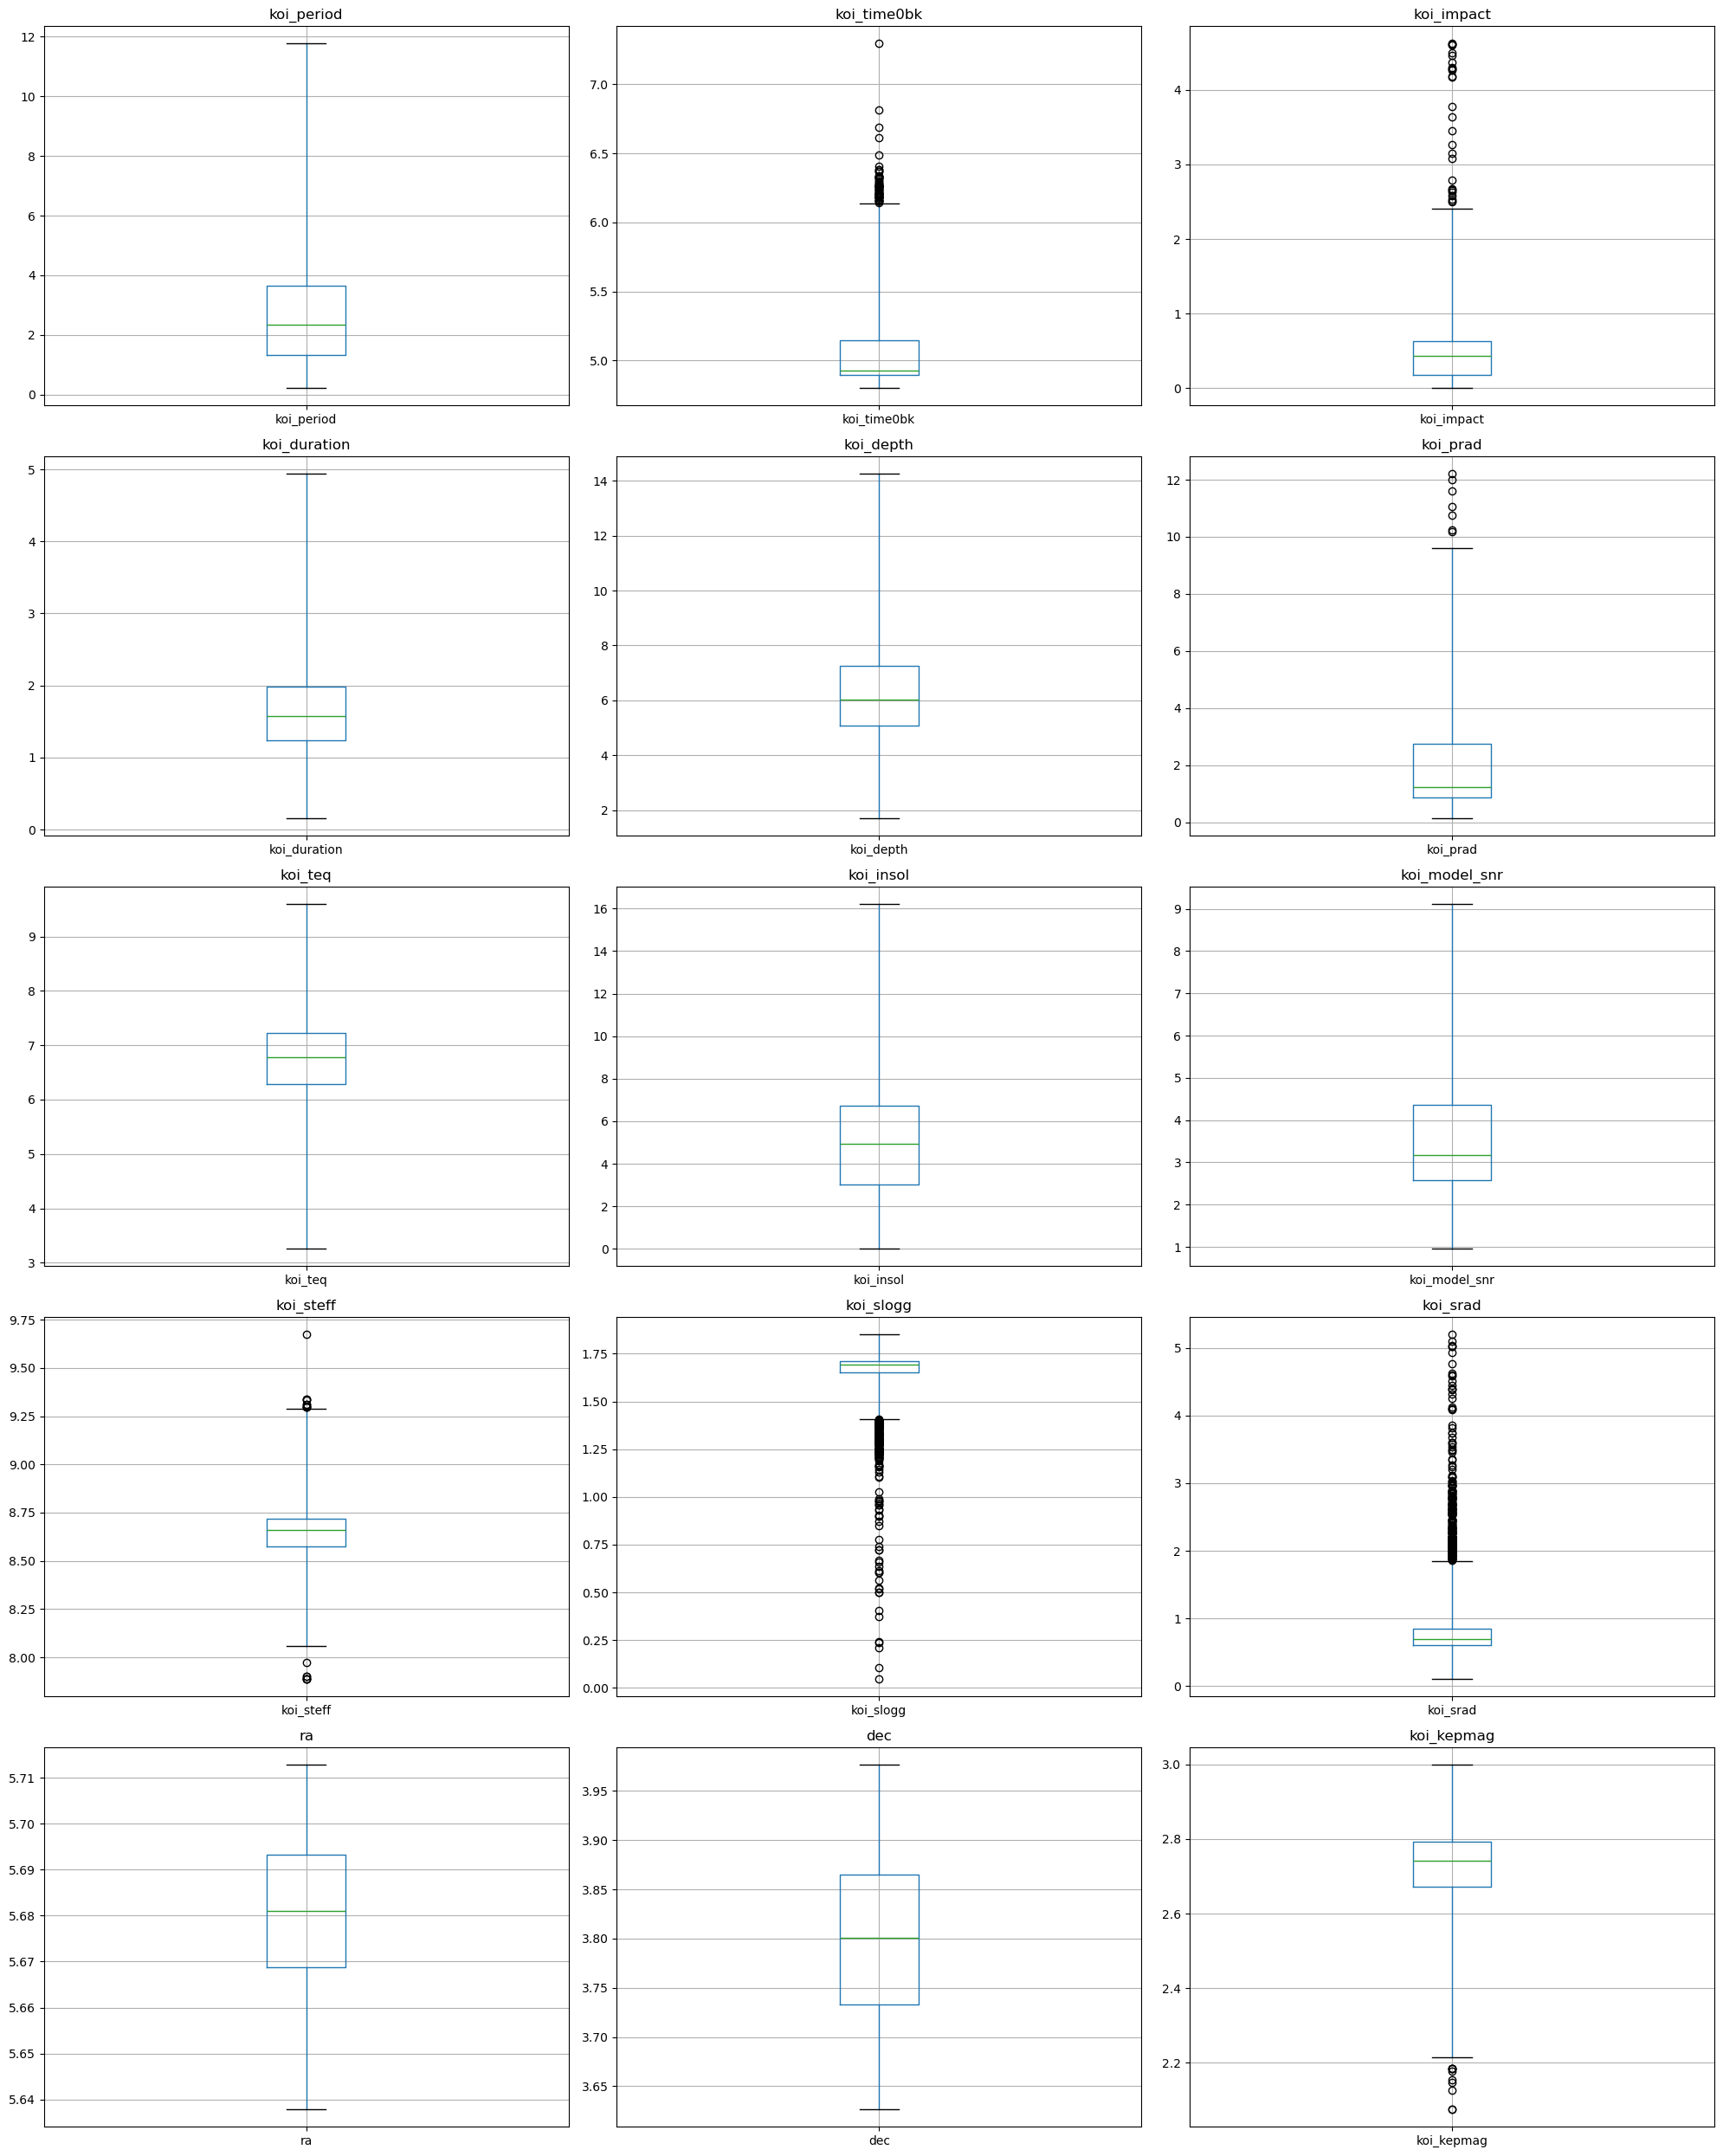

In [19]:
#Plot whisker plots of prsnt_err_abs to see outliers
# Setting up the figure with 5 rows and 4 columns
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iterating

# Plotting boxplots for each column
for i, col in enumerate(kois_log.columns[4:-1]): #we excluded our binary categorical variables and target variable for the graph
    kois_log.boxplot(column=col, ax=axes[i], whis=4)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [20]:
#remove outliers visually based on whisker plots rather than IQR range
kois_log = kois_log[kois_log['koi_time0bk'] < 6.4]
kois_log = kois_log[kois_log['koi_impact'] < 2.5]
kois_log = kois_log[kois_log['koi_prad'] < 9.5]
kois_log = kois_log[kois_log['koi_steff'].between(8, 9.3)]
kois_log = kois_log[kois_log['koi_slogg'] > 1]
kois_log = kois_log[kois_log['koi_srad'] < 3]

kois_log.shape

(8915, 20)

In [21]:
# Calculate Q1 and Q3
Q1 = kois_log.quantile(0.25)
Q3 = kois_log.quantile(0.75)

# Calculate the Interquartile Range
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR
outliers = (kois_log > (Q3 + 1.5 * IQR))

# Filter out the outliers
kois_no_outliers = kois_log[~outliers.any(axis=1)]

In [22]:
#print the shape of our original data and our new dataset with no outliers
print(f"Original Dataset: {kois.shape}")
print(f"Dataset w/o Outlier: {kois_no_outliers.shape}")

Original Dataset: (9007, 40)
Dataset w/o Outlier: (3854, 20)


We can see from the above that we have eliminated about 1050 values that were categorized as outliers. As this is a large portion of our data, we will instead remove outliers based on whisker plots of the log values. 

In [23]:
#convert kois_log back to original values
kois_no_outliers = kois_log.copy()
kois_no_outliers.iloc[:, 4:-1] = np.expm1(kois_log.iloc[:, 4:-1])
kois_no_outliers.shape

(8915, 20)

In [221]:
sns.pairplot(kois_no_outliers, hue='koi_disposition_encoded', corner=True)

In [24]:
#separate our target variable from the rest of the data
y_no_outliers = kois_no_outliers['koi_disposition_encoded']
X_no_outliers = kois_no_outliers.drop(['koi_disposition_encoded'], axis=1)

In [25]:
#split the data into training and testing sets
#NO suffix is for no outliers
X_train_NO, X_test_NO, y_train_NO, y_test_NO = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42) #use a test size of 20%

Fit model with Outliers removed

In [26]:
#train Decision tree classifier
dtc.fit(X_train_NO, y_train_NO)

#train Random forest classifier
rfc.fit(X_train_NO, y_train_NO)

#train Logistic regression classifier
logreg.fit(X_train_NO, y_train_NO)

#train Support vector machine classifier
svc.fit(X_train_NO, y_train_NO)

#train K-nearest neighbors classifier
knn.fit(X_train_NO, y_train_NO)

#train XGBoost classifier
xgbc.fit(X_train_NO, y_train_NO)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Performance of models with outliers removed, and scaled data

In [27]:
# Decision tree classifier F1-score
dtc_f1_score = f1_score(y_test_NO, dtc.predict(X_test_NO), average='macro')

# Random forest classifier F1-score
rfc_f1_score = f1_score(y_test_NO, rfc.predict(X_test_NO), average='macro')

# Logistic regression classifier F1-score
logreg_f1_score = f1_score(y_test_NO, logreg.predict(X_test_NO), average='macro')

# Support vector machine classifier F1-score
svc_f1_score = f1_score(y_test_NO, svc.predict(X_test_NO), average='macro')

# K-nearest neighbors classifier F1-score
knn_f1_score = f1_score(y_test_NO, knn.predict(X_test_NO), average='macro')

# XGBoost classifier F1-score
xgbc_f1_score = f1_score(y_test_NO, xgbc.predict(X_test_NO), average='macro')

In [31]:
#Print the scores

# Create a dictionary with the model names and their scores
model_scores_NO = {
    "Decision Tree": dtc_f1_score,
    "Random Forest": rfc_f1_score,
    "Logistic Regression": logreg_f1_score,
    "SVM": svc_f1_score,
    "KNN": knn_f1_score,
    "XGBoost": xgbc_f1_score
}

# Convert the dictionary to a DataFrame
scores_NO = pd.DataFrame(list(model_scores_NO.items()), columns=['Model-No-Outliers', 'F1-Score'])

# Sort the DataFrame by 'Accuracy Score' in descending order
scores_NO = scores_NO.sort_values(by='F1-Score', ascending=False)

# Display the DataFrame for both sets of scores
print(scores_df)
print(scores_NO)

#pring base classification report
print(f"\n Classification Report for XGBoost: \n{base_report}")
print(f"\n Classification Report for XGBoost w/o Outliers: \n{classification_report(y_test_NO, xgbc.predict(X_test_NO))}")

            Model-Base  F1-Score
1        Random Forest  0.864087
5              XGBoost  0.863201
0        Decision Tree  0.809189
4                  KNN  0.582187
2  Logistic Regression  0.469997
3                  SVM  0.219409
     Model-No-Outliers  F1-Score
5              XGBoost  0.864395
1        Random Forest  0.863585
0        Decision Tree  0.807614
4                  KNN  0.574978
2  Logistic Regression  0.478889
3                  SVM  0.217265

 Classification Report for XGBoost: 
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       452
           1       0.80      0.82      0.81       466
           2       0.99      0.99      0.99       884

    accuracy                           0.89      1802
   macro avg       0.86      0.86      0.86      1802
weighted avg       0.89      0.89      0.89      1802


 Classification Report for XGBoost w/o Outliers: 
              precision    recall  f1-score   support

           0 

We saw drastic performance loss in some of our models, and even some performance loss in our top performaning models. This indicates that the so-called outliers, can not simply be filtered out using the methods that were employed. We will continue with the data as is, and look at other possibilities for preprocessing that may improve performance. 

### Logarithmic Scaling

As we saw in our data exploration, as well as when viewing the descriptive statistics of our cleaned dataset, there was a very wide range of values for many of the variables. Despite the scaling, these extreme values can still negatively impact our model performance. Another method for dealing with extreme values is log scaling. 

Log scaling also makes sense in the context of our data as it is measurements on an astronomical scale, where magnitudes can very logarithmically.

As there are no built in log-scalers, we can create our own. 

In [32]:
#Import relevant libraries
from sklearn.base import BaseEstimator, TransformerMixin

#Create a class to scale the data using the log function from numpy
class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-5):
        self.epsilon = epsilon  # Small constant to handle zero values

    def fit(self, X, y=None):
        return self

    #ned to take the absolute value of the data to avoid errors
    def transform(self, X):
        return np.log1p(np.abs(X + self.epsilon))

In [33]:
#apply the log scaler to the data
log_scaler = LogScaler(epsilon=1e-5)

X_train_log = log_scaler.fit_transform(X_train)
X_test_log = log_scaler.transform(X_test)

We can train our models without our Standard or MinMax Scalers to compare performance:

In [34]:
#train Decision tree classifier
dtc.fit(X_train_log, y_train)

#train Random forest classifier
rfc.fit(X_train_log, y_train)

#train Logistic regression classifier
logreg.fit(X_train_log, y_train)

#train Support vector machine classifier
svc.fit(X_train_log, y_train)

#train K-nearest neighbors classifier
knn.fit(X_train_log, y_train)

#train XGBoost classifier
xgbc.fit(X_train_log, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
# Decision tree classifier F1-score
dtc_f1_score = f1_score(y_test, dtc.predict(X_test_log), average='macro')

# Random forest classifier F1-score
rfc_f1_score = f1_score(y_test, rfc.predict(X_test_log), average='macro')

# Logistic regression classifier F1-score
logreg_f1_score = f1_score(y_test, logreg.predict(X_test_log), average='macro')

# Support vector machine classifier F1-score
svc_f1_score = f1_score(y_test, svc.predict(X_test_log), average='macro')

# K-nearest neighbors classifier F1-score
knn_f1_score = f1_score(y_test, knn.predict(X_test_log), average='macro')

# XGBoost classifier F1-score
xgbc_f1_score = f1_score(y_test, xgbc.predict(X_test_log), average='macro')

Compare with our scaled data using normal transformers:

In [36]:
#Print the scores

# Create a dictionary with the model names and their scores
model_scores_log = {
    "Decision Tree": dtc_f1_score,
    "Random Forest": rfc_f1_score,
    "Logistic Regression": logreg_f1_score,
    "SVM": svc_f1_score,
    "KNN": knn_f1_score,
    "XGBoost": xgbc_f1_score
}
# Convert the dictionary to a DataFrame
scores_log = pd.DataFrame(list(model_scores_log.items()), columns=['Model-Log-Scaling', 'F1-Score'])

# Sort the DataFrame by 'Accuracy Score' in descending order
scores_log = scores_log.sort_values(by='F1-Score', ascending=False)

# Display the DataFrame for both sets of scores
print(scores_scaled)
print(scores_log)

print(f"\n Classification Report for XGBoost: \n{classification_report(y_test, xgbc.predict(X_test_log))}")
print(f"\n Classification Report for Random Forest: \n{classification_report(y_test, rfc.predict(X_test_minmax))}")
print(f"\n Classification Report for Logistic Regression: \n{classification_report(y_test, logreg.predict(X_test_stndrd))}")
print(f"\n Classification Report for SVM: \n{classification_report(y_test, svc.predict(X_test_minmax))}")
print(f"\n Classification Report for Decision Tree: \n{classification_report(y_test, dtc.predict(X_test_minmax))}")
print(f"\n Classification Report for KNN: \n{classification_report(y_test, knn.predict(X_test_minmax))}")

         Model-Scaling  F1-Score
5              XGBoost  0.863201
1        Random Forest  0.859486
2  Logistic Regression  0.840385
3                  SVM  0.830852
0        Decision Tree  0.807556
4                  KNN  0.751324
     Model-Log-Scaling  F1-Score
5              XGBoost  0.866917
1        Random Forest  0.866904
2  Logistic Regression  0.865579
3                  SVM  0.833056
0        Decision Tree  0.819458
4                  KNN  0.765298

 Classification Report for XGBoost: 
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       452
           1       0.80      0.83      0.82       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802


 Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0       0

Looking at the output from our `classification_report`, we see some obvious issues with the performance of our models. XGBoost out of the box is doing okay, but still favours the majority class. 

Random Forest had precision, recall and f1-score for 1 (a CONFIRMED exoplanet) of zero. Meaning it may have only ever predicted 0 and 2 for all test values. 

Logistic Regression has okay scores for class 2 (FALSE POSITIVE), but very poor scores for our CONFIRMED class. 

These types of patterns of poor performance are similar for the remaining models.

### Feature Selection

As a next step, we are going to perorm feature selection to see if we can out do any of the above scores. 

The most basic feature selection method we can apply, is simply removing columns we suspect may negatively impact model performance. Essentially we can complete this, then compare performance. 

To start off, we can remove the error columns, which constitute about 2/3rds of the columns. 

In [37]:
#remove error columns from kois
kois_no_err = kois.loc[:, ~kois.columns.str.contains('_err')]
print(kois_no_err.shape)
kois_no_err.head()

(9007, 20)


,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,koi_disposition_encoded
rowid,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
2,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
3,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129,15.436,2
4,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597,2
5,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509,1


In [38]:
#separate our target variable from the rest of the data
y_no_err = kois_no_err['koi_disposition_encoded']
X_no_err = kois_no_err.drop(['koi_disposition_encoded'], axis=1)

#split the data into training and testing sets
X_train_no_err, X_test_no_err, y_train_no_err, y_test_no_err = train_test_split(X_no_err, y_no_err, test_size=0.2, random_state=42) #use a test size of 20%

We will stick to XGBoost moving forward as it is has been our best performing model.

In [39]:
#train XGBoost classifier
xgbc.fit(X_train_no_err, y_train_no_err)

#XGBoost classifier score
xgbc_score = xgbc.score(X_test_no_err, y_test_no_err)

#classification report for base model and XGBoost
no_err_report = classification_report(y_test_no_err, xgbc.predict(X_test_no_err))
print(f"\n Base Model Classification Report: \n{base_report}")
print(f"\n Classification Report for XGBoost with error columns removed: \n{no_err_report}")


 Base Model Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       452
           1       0.80      0.82      0.81       466
           2       0.99      0.99      0.99       884

    accuracy                           0.89      1802
   macro avg       0.86      0.86      0.86      1802
weighted avg       0.89      0.89      0.89      1802


 Classification Report for XGBoost with error columns removed: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802



We can see when comparing to the base report, that we see some slight performance improvements by dropping the error columns. 

We can apply a couple more methods before we make a decision as to the best approach for feature selection. 

Applying Domain Knowledge

Looking at the pairplot, there were two charts that showed very obvious relationships between independent variables. These being `koi_insol` and `koi_teq`, and then `koi_slog` and `koi_srad`. The relationships are roughly summarized below
- Both `koi_insol` and `koi_teq` are measures of the planets temperatue, with `koi_insol` being a measurement of flux. 
    - Since they measure the same thing we can remove `koi_insol`
- `koi_slogg` is the acceleration due to gravity, and `koi_srad` is the "photospheric radius" of the star, which gravity can be directly derived from
    - As a result we will remove `koi_slogg` since it can likely be calculated from `koi_srad`

In [ ]:
#Using our dataset without error columns, remove koi_insol, and koi_slogg
kois_no_err = kois_no_err.drop(['koi_insol', 'koi_slogg'], axis=1)

In [42]:

#split our data into training and testing sets
y_no_err = kois_no_err['koi_disposition_encoded']
X_no_err = kois_no_err.drop(['koi_disposition_encoded'], axis=1)

X_train_no_err, X_test_no_err, y_train_no_err, y_test_no_err = train_test_split(X_no_err, y_no_err, test_size=0.2, random_state=42) #use a test size of 20%

In [44]:
#retrain our model
xgbc.fit(X_train_no_err, y_train_no_err)

#evaluate with f1-score
xgbc_f1_score = f1_score(y_test_no_err, xgbc.predict(X_test_no_err), average='macro')

#save classification report
no_err_report2 = classification_report(y_test_no_err, xgbc.predict(X_test_no_err))

#print classification report - base model and no error (and 2 other columns)
print(f"\n Base Model Classification Report: \n{no_err_report}")
print(f"\n Classification Report for XGBoost with error columns, slogg, and insol removed: \n{no_err_report2}")


 Base Model Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802


 Classification Report for XGBoost with error columns, slogg, and insol removed: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       452
           1       0.81      0.83      0.82       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802



We saw a sligth drop in performance (we need to view macro average). So we can keep `koi_slog` and `koi_insol` in our dataset.

#### Other Feature Selection Methods:

In [46]:
#import feature selection tools
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFdr, chi2
from sklearn.metrics import f1_score

In [47]:
#splitting data into numerical and categorical features as we want to evaluate them with different metrics
X_train_num = X_train.iloc[:, 4:]
X_test_num = X_test.iloc[:, 4:]

X_train_cat = X_train.iloc[:, :4]
X_test_cat = X_test.iloc[:, :4]

print(f"Numerical Train set shape: {X_train_num.shape}")
print(f"Numerical test set shape: {X_test_num.shape}")
print(f"Categorical Train set shape: {X_train_cat.shape}")
print(f"Categorical test set shape: {X_test_cat.shape}")

Numerical Train set shape: (7205, 35)
Numerical test set shape: (1802, 35)
Categorical Train set shape: (7205, 4)
Categorical test set shape: (1802, 4)


Perform Feature Selection on Numerical Features:

In [56]:
#Range of k to try with KBest
k_values = range(1, X_train_num.shape[1]+1)

#initiate best score and best k variables
best_score_num = 0
best_k_num = 0

for k in k_values:
    #apply feature selection to the data
    fs = SelectKBest(score_func=f_classif, k=k)
    #fit the feature selector to the training data
    X_selected = fs.fit_transform(X_train_num, y_train)
    #transform the test data
    X_test_selected = fs.transform(X_test_num)
    
    #fit the model on select features
    xgbc.fit(X_selected, y_train)
    
    #make predictions and evaluate
    y_pred = xgbc.predict(X_test_selected)
    score = f1_score(y_test, y_pred, average='macro')

    #check to see if the new score is better than the previous best
    if score > best_score_num:
        best_score_num = score
        best_k_num = k
        xgboost_clf_report = classification_report(y_test, xgbc.predict(X_test_selected))


#check the shape of the selected data
print(f'Best F1-Score: {best_score_num} achieve with k={best_k_num} numerical features')

Best F1-Score: 0.7370114969035345 achieve with k=26 numerical features


Perform Feature Selection on Categorical Features:

In [57]:
#range of k to try with KBest
k_values_cat = range(1, X_train_cat.shape[1] + 1)

#initiate best score and best k variables
best_score_cat = 0
best_k_cat = 0

for k in k_values_cat:
    #apply feature selection to the data
    fs_cat = SelectKBest(score_func=chi2, k=k)
    #fit the feature selector to the training data
    X_selected_cat = fs_cat.fit_transform(X_train_cat, y_train)
    #transform the test data
    X_test_selected_cat = fs_cat.transform(X_test_cat)
    
    X_train_combined = np.hstack((X_selected, X_selected_cat))
    X_test_combined = np.hstack((X_test_selected, X_test_selected_cat))

    #fit the model on select features
    xgbc.fit(X_train_combined, y_train)

    #make predictions and evaluate
    y_pred_combined = xgbc.predict(X_test_combined)
    score_combined = f1_score(y_test, y_pred_combined, average='macro')

    #check to see if the new score is better than the previous best
    if score_combined > best_score_cat:
        best_score_cat = score_combined
        best_k_cat = k
        xgboost_clf_report = classification_report(y_test, xgbc.predict(X_test_combined))

#check the shape of the selected data
print(f'Best F1-Score: {best_score_cat} achieve with k={best_k_cat} numerical features')

Best F1-Score: 0.8706684679091566 achieve with k=4 numerical features


From the above results, our best set of features is all 4 categorical features, and 26 of our numerical features. This means that KBest thinks that some of the error columns should be included. 

In [58]:
#train the XGBoost model using the subset of features
xgbc.fit(X_selected, y_train)

#XGBoost classifier score
xgbc_score_kbest = xgbc.score(X_test_selected, y_test)

print(f"\nClassification Report for XGBoost with error columns removed: \n{no_err_report}")
print(f"\nClassification Report for XGBoost \nWith {best_k_cat} KBest categorical and {best_k_num} numerical features: \n{xgboost_clf_report}")


Classification Report for XGBoost with error columns removed: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802


Classification Report for XGBoost 
With 4 KBest categorical and 26 numerical features: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       452
           1       0.81      0.83      0.82       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802



Comparing the evaluation metrics using KBest, and simply removing the error columns, we see that removing the error columns actually out performs the KBest method slightly. For the rest of our model tuning, we continue with the copy of the dataset that removed these columns.

We can perform feature selection on this subset to see if there is any increase in performance.

In [60]:
X_train_no_err, X_test_no_err, _, _ = train_test_split(X_no_err, y_no_err, test_size=0.2, random_state=42) #use a test size of 20%

In [61]:
#splitting data into numerical and categorical features
X_train_num = X_train_no_err.iloc[:, 4:]
X_test_num = X_test_no_err.iloc[:, 4:]

X_train_cat = X_train_no_err.iloc[:, :4]
X_test_cat = X_test_no_err.iloc[:, :4]

print(f"Numerical Train set shape: {X_train_num.shape}")
print(f"Numerical test set shape: {X_test_num.shape}")
print(f"Categorical Train set shape: {X_train_cat.shape}")
print(f"Categorical test set shape: {X_test_cat.shape}")

Numerical Train set shape: (7205, 13)
Numerical test set shape: (1802, 13)
Categorical Train set shape: (7205, 4)
Categorical test set shape: (1802, 4)


In [62]:
#Range of k to try with KBest
k_values = range(1, X_train_num.shape[1]+1)

best_score = 0
best_k = 0

for k in k_values:
    #apply feature selection to the data
    fs = SelectKBest(score_func=f_classif, k=k)
    #fit the feature selector to the training data
    X_selected = fs.fit_transform(X_train_num, y_train)
    #transform the test data
    X_test_selected = fs.transform(X_test_num)
    
    #fit the model on select features
    xgbc.fit(X_selected, y_train)
    
    #make predictions and evaluate
    y_pred = xgbc.predict(X_test_selected)
    score = f1_score(y_test, y_pred, average='weighted')

    #check to see if the new score is better than the previous best
    if score > best_score:
        best_score = score
        best_k_num = k

print(f'Best F1-Score: {best_score} achieve with k={best_k_num} numerical features')

Best F1-Score: 0.7621512181301435 achieve with k=11 numerical features


In [63]:
#Same code as before but with error columns removed
#range of k to try with KBest
k_values_cat = range(1, X_train_cat.shape[1] + 1)
best_score_cat = 0
best_k_cat = 0

for k in k_values_cat:
    #apply feature selection to the data
    fs_cat = SelectKBest(score_func=chi2, k=k)
    #fit the feature selector to the training data
    X_selected_cat = fs_cat.fit_transform(X_train_cat, y_train)
    #transform the test data
    X_test_selected_cat = fs_cat.transform(X_test_cat)
    
    X_train_combined = np.hstack((X_selected, X_selected_cat))
    X_test_combined = np.hstack((X_test_selected, X_test_selected_cat))

    #fit the model on select features
    xgbc.fit(X_train_combined, y_train)

    #make predictions and evaluate
    y_pred_combined = xgbc.predict(X_test_combined)
    score_combined = f1_score(y_test, y_pred_combined, average='weighted')

    #check to see if the new score is better than the previous best
    if score_combined > best_score_cat:
        best_score_cat = score_combined
        best_k_cat = k
        xgboost_clf_report = classification_report(y_test, xgbc.predict(X_test_combined))
        
print(f'Best F1-Score: {best_score_cat} achieve with k={best_k_cat} categorical features')

Best F1-Score: 0.9004719666389821 achieve with k=4 categorical features


In [64]:
print(f"\nClassification Report for XGBoost with error columns removed: \n{no_err_report}")
print(f"\nClassification Report for XGBoost \nWith {best_k_cat} KBest categorical and {best_k_num} numerical features: \n{xgboost_clf_report}")


Classification Report for XGBoost with error columns removed: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802


Classification Report for XGBoost 
With 4 KBest categorical and 11 numerical features: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       452
           1       0.81      0.83      0.82       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802



Our feature selection shows that reducing the numerical or categorical variables *after* dropping the error columns does not improve performance. As such we will stick with our dataset with just the error columns dropped. 

In [65]:
kois_no_err.shape
kois_no_err.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_model_snr,koi_steff,koi_srad,ra,dec,koi_kepmag,koi_disposition_encoded
rowid,,,,,,,,,,,,,,,,,,
1,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,35.8,5455.0,0.927,291.93423,48.141651,15.347,1
2,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,25.8,5455.0,0.927,291.93423,48.141651,15.347,1
3,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,76.3,5853.0,0.868,297.00482,48.134129,15.436,2
4,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,505.6,5805.0,0.791,285.53461,48.285210,15.597,2
5,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,40.9,6031.0,1.046,288.75488,48.226200,15.509,1


### Handling Class Imbalance

The next step in our preprocessing will be handling class imbalance. From our evaluation metrics, we can see that the model is still biased towards our majority class, but we are most interested in our CONFIRMED exoplanets, or `koi_disposition_encoded` = 1

Percent of Total Dispositions for Each Target Variable: 
koi_disposition_encoded
2    0.505385
1    0.254469
0    0.240147
Name: proportion, dtype: float64


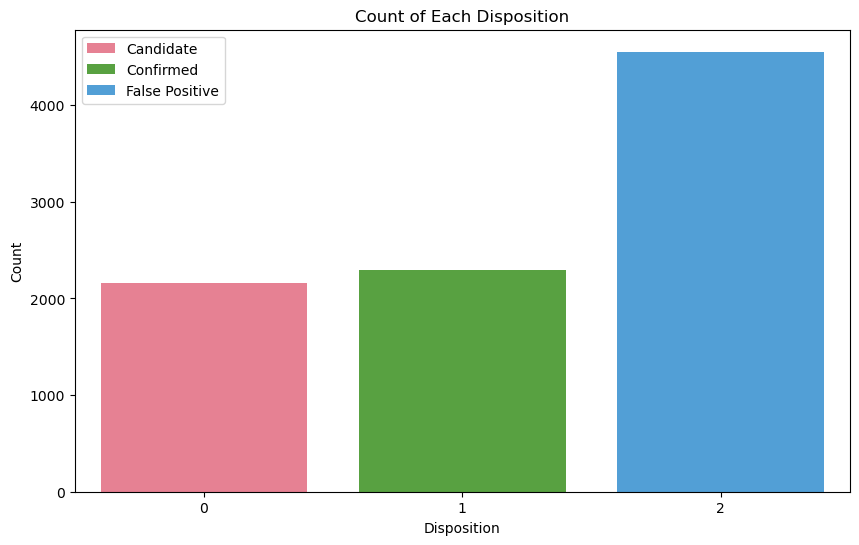

In [66]:
#Show the distribution of each class as a percentage and in a chart
print(f"Percent of Total Dispositions for Each Target Variable: \n{y_no_err.value_counts(normalize=True)}")

#plot the distribution of each class in koi_disposition_encoded
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_no_err, 
              palette='husl')

plt.xlabel('Disposition')
plt.ylabel('Count')
plt.title('Count of Each Disposition')
plt.legend(['Candidate', 'Confirmed', 'False Positive'])
plt.show()

In order to handle the class imbalance, we will apply SMOTE, to generate additional synthetic samples in order to balance out the distribution of our target classes. 

In [67]:
smote = SMOTE(random_state=23)

X_train_smote, y_train_smote = smote.fit_resample(X_train_no_err, y_train_no_err)

In [68]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(11004, 17)
(11004,)


Percent of Total Dispositions for Each Target Variable: 
koi_disposition_encoded
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64


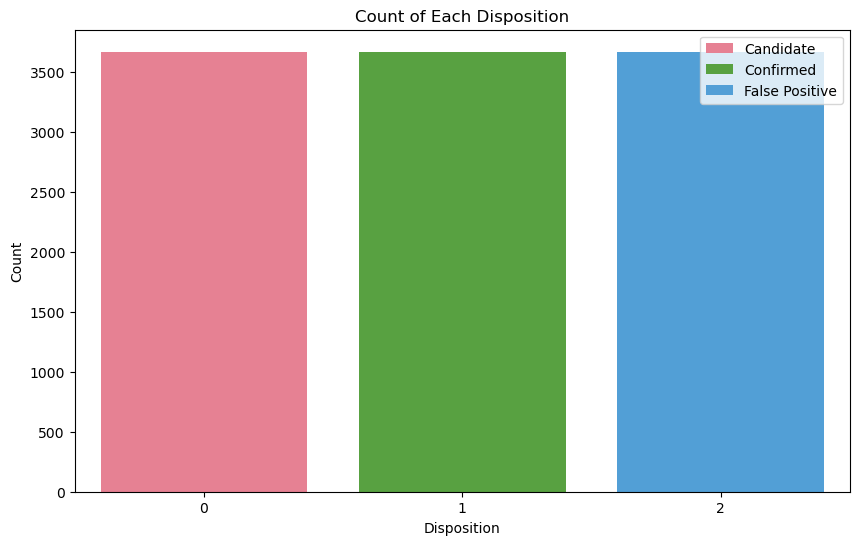

In [69]:
#Show the distribution of each class as a percentage and in a chart
print(f"Percent of Total Dispositions for Each Target Variable: \n{y_train_smote.value_counts(normalize=True)}")

#plot the distribution of each class in koi_disposition_encoded
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_smote, 
              palette='husl')

plt.xlabel('Disposition')
plt.ylabel('Count')
plt.title('Count of Each Disposition')
plt.legend(['Candidate', 'Confirmed', 'False Positive'])
plt.show()

In [72]:
smote_model = xgbc.fit(X_train_smote, y_train_smote)
smote_score = smote_model.score(X_test_no_err, y_test_no_err)

smote_clf_report = classification_report(y_test_no_err, smote_model.predict(X_test_no_err))

#print our report with error columns removed and the report for our SMOTE model
print(f"\nClassification Report for XGBoost with error columns removed: \n{no_err_report}")
print(f"\nClassification Report for XGBoost with SMOTE: \n{smote_clf_report}")


Classification Report for XGBoost with error columns removed: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802


Classification Report for XGBoost with SMOTE: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       452
           1       0.81      0.81      0.81       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802



Again, we fail to improve on or outperform the model with just the error columns removed. 

### Cross Validation

We can perform cross validation on the balanced data set as well as our original dataset to ensure our model generalizes well. 

In [73]:
# Define Stratified K-Fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store the F1 score of each fold
fold_f1_scores = []

# Perform Stratified K-Fold CV on the SMOTE data
for train_index, val_index in stratified_kfold.split(X_train_smote, y_train_smote):
    
    X_train_fold = X_train_smote.iloc[train_index]
    X_val_fold = X_train_smote.iloc[val_index]
    y_train_fold = y_train_smote.iloc[train_index]
    y_val_fold = y_train_smote.iloc[val_index]

    # Fit the model on the fold's training data
    xgbc.fit(X_train_fold, y_train_fold)

    # Predict on the fold's validation data
    y_pred_fold = xgbc.predict(X_val_fold)

    # Calculate F1 score and append to the list - macro used as we are interested in the average of the less frequent classes
    fold_f1_score = f1_score(y_val_fold, y_pred_fold, average='macro')
    fold_f1_scores.append(fold_f1_score)

# Calculate and print the average F1 score across all folds
average_f1_score = np.mean(fold_f1_scores)
print(f"Average Cross-Validation F1 Score: {average_f1_score:.4f}")

# After cross-validation, fit the model on the full SMOTE-applied training set
xgbc.fit(X_train_smote, y_train_smote)

# Finally, evaluate the model on the original, untouched test set
y_test_pred = xgbc.predict(X_test_no_err)
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
print(f"Test Set F1 Score: {test_f1_score:.4f}")

Average Cross-Validation F1 Score: 0.9153
Test Set F1 Score: 0.8665


### Confusion Matrix

After evaluation, we can use a confusiong matrix to determine the type of errors our model is making. 

<Axes: >

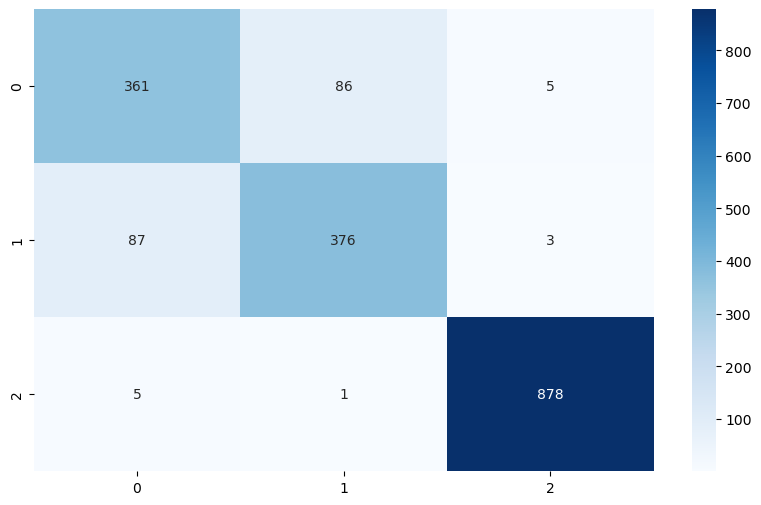

In [74]:
#Confusion matrix for the model
cm = confusion_matrix(y_test_no_err, y_test_pred)

#plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

From the above confusion matrix, we should be quite happy with our model performance. Essentially, the model is able to predict false positives well, and then has some minor issues determining the difference between CANDIDATE and CONFIRMED exoplanets, which makes sense considering our understanding of the data. 

The "CANDIDATE" exoplanets, have not yet been confirmed, or in otherwords the confidence that they are an Exoplanet is not high enough to give them a CONFIRMED label. Let's look at our classification report as well:

In [75]:
#classification report for the model
print(f"Classification Report for Model with SMOTE Dataset:\n {classification_report(y_test_no_err, y_test_pred)}")
#print original classification report for comparison
print(f"\nClassification Report for Model with Original Dataset:\n {no_err_report}")

Classification Report for Model with SMOTE Dataset:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       452
           1       0.81      0.81      0.81       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.87      0.87      0.87      1802
weighted avg       0.90      0.90      0.90      1802


Classification Report for Model with Original Dataset:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       452
           1       0.81      0.84      0.83       466
           2       0.99      0.99      0.99       884

    accuracy                           0.90      1802
   macro avg       0.88      0.88      0.88      1802
weighted avg       0.90      0.90      0.90      1802



We actually see nearly identical performance, but with a slight drop in the f1-score for identifying CONFIRMED samples. Let's plot a confusion matrix of our model with simply the error columns removed. Our macro avg score is also slightly higher for the report with only the error columns removed. 

<Axes: >

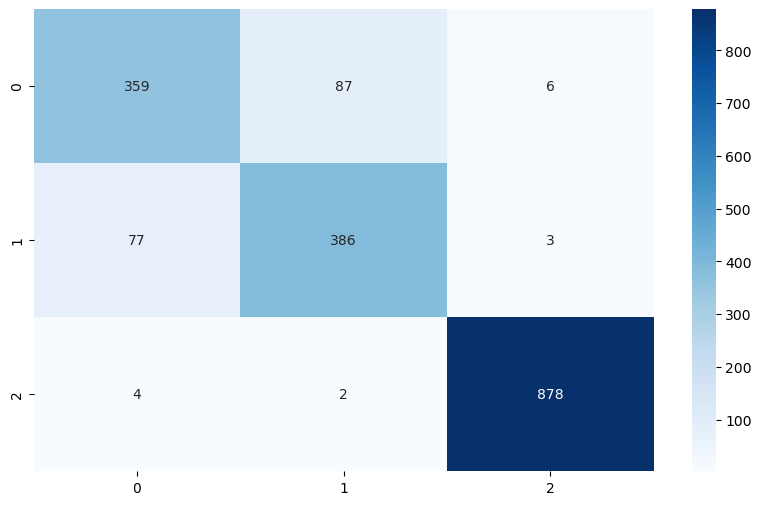

In [76]:
#rerun the model with the original data with only errors removed
xgbc.fit(X_train_no_err, y_train_no_err)

#confusion matrix with original data with only errors removed
cm = confusion_matrix(y_test_no_err, xgbc.predict(X_test_no_err))

#plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

From the above confusion matrix, we can see there is a slight shift in where the errors occur. But one takeaway, is that our ability to accurately predict confirmed Exoplanets has gone up ever so slightly. As that is the main goal, we will stick with this model moving forward. 

Final steps for preprocessing will be saving the model, which we can then use in another notebook. There we will fine tune our model using hyperparamter tuning techniques, and complete a final evaluation. 

Final check to ensure we have our correct model:

In [77]:
X_train_no_err.shape

(7205, 17)

In [78]:
y_train_no_err.shape

(7205,)

In [79]:
#retrain model but this time saving it as a variable
final_model = xgbc.fit(X_train_no_err, y_train_no_err)

In [ ]:
#same the model with pickle
import pickle

#save the model
filename = 'xgboost_model.sav'

pickle.dump(final_model, open(filename, 'wb'))